# Topic Modeling of the American Presidential Inaugarations dataset with LDA

## Set up

### Install necessary packages

In [1]:
#pip install --upgrade opendatasets numpy pandas scipy scikit-learn matplotlib seaborn gensim wordcloud nltk

### Import packages

In [2]:
import os
import numpy as np
import pandas as pd
import gensim as gm
import seaborn as sns
import opendatasets as od
import regex as re
import string
import nltk
from pprint import pprint
from sklearn.manifold import TSNE
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib import pyplot as plt
from wordcloud import WordCloud as wc
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from tqdm.notebook import tqdm
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### Download Data
For this step, we need the `kaggle` api which was installed above. Please follow these instructions:
1. Create a kaggle account
2. Navigate to https://kaggle.com/`username`/account -> `API` -> `Create New API Token` 
3. Move the downloaded `kaggle.json` file to `~/.kaggle/` using a command such as `mv ~/Downloads/kaggle.json ~/.kaggle/` from the CLI or using your machine's gui`
4. Open the kaggle.json you should see something like `{"username":"[USERNAME]","key":"[KEY]"}`. Copy `KEY` to your clipboard
5. Run the command below and follow the prompts
6. Done! You should see `inaug_speeches.csv` in `./data` dir.

In [3]:
od.download('https://www.kaggle.com/datasets/adhok93/presidentialaddress',data_dir='.',force=True)
os.rename('presidentialaddress/inaug_speeches.csv','./inaug_speeches.csv')
os.rmdir('presidentialaddress')

### Helper Functions

In [4]:
def clean_raw_data(text):
    '''Make text lowercase, remove text in square brackets, 
    remove punctuation, remove read errors,
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', ' ', text) #remove unicode
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text) #remove punctuations
    text = re.sub('\w*\d\w*', ' ', text) 
    return text
def tokenize_words(txt):
    tokenized = word_tokenize(txt) #tokenize words
    return tokenized

def remove_stopwords(tokenized_txt):
    stop_words = nltk.corpus.stopwords.words('english')
    cleaned_text_array = [word for word in tokenized_txt if word not in stop_words] #remove stop words
    return cleaned_text_array

def word_lemmatizer(tokenized_text_without_stopwords):
    wordnet_lemmatizer = WordNetLemmatizer()
    lemmatized = [wordnet_lemmatizer.lemmatize(word) for word in tokenized_text_without_stopwords] #lemmatize words
    return ' '.join(lemmatized)
def preprocess(raw_data):
    # Clean Speech Text
    raw_data["text"] = raw_data["text"].apply(lambda x: clean_raw_data(x))
    raw_data['tokenized_text']=raw_data['text'].apply(tokenize_words)
    raw_data['Inaugural Address']=raw_data['Inaugural Address'].apply(lambda x: 2 if 'second' in x.lower() else 1)
    raw_data['tokenized_text_without_stopwords'] = raw_data['tokenized_text'].apply(lambda x: remove_stopwords(x))
    raw_data['lemmatized_tok_txt_wo_stopwords'] = raw_data['tokenized_text_without_stopwords'].apply(lambda x: word_lemmatizer(x))
    additional_stop_words = ["fellow","america", 'today', 'thing']
    stop_words_aggr = text.ENGLISH_STOP_WORDS.union(additional_stop_words)
    tfidf = TfidfVectorizer(stop_words=stop_words_aggr, ngram_range = (1,1), max_df = .8, min_df = .01)
    tfidf_transformed = tfidf.fit_transform(raw_data.lemmatized_tok_txt_wo_stopwords)
    return raw_data,tfidf_transformed,tfidf

In [5]:
def word2topic_gensim(lda_model,text,id2word,n_topics,n_terms=5):
    top_k_words = lda_model.show_topics(num_topics = n_topics,num_words=n_terms) #get top n_terms for each of the n_topics
    top_k_words = {i:top_k_words[i][1].split("\"")[1::2] for i in range(len(top_k_words))} #convert to dict
    return top_k_words
def word2topic_sklearn(word_topic_probs,n_terms,n_topics,words):
    n_topics = len(word_topic_probs)
    words = {ind:word for word,ind in words.items()}
    words = pd.DataFrame(words.values(),columns=['Word'])
    top_k_inds = np.argsort(word_topic_probs[:n_topics,:],axis=-1) #sort by increasing values
    top_k_inds = top_k_inds[:,:-n_terms-1:-1] #get top n_terms for n_topics
    terms={}
    for i in range(n_topics):
        inds = top_k_inds[i]
        terms[i] = [word for word in words.iloc[inds]['Word']] #add to dict
    return terms
def topics2docs_gensim(model,docs,n_topics):
    '''
    get top n_topics topics for each doc based on gensim model
    '''
    topics = {}
    for i in range(docs.shape[0]):
        dist = model.get_document_topics(gm.matutils.Sparse2Corpus(X)[i])
        dist_array = np.array([prob[-1] for prob in dist])
        sorted_dist_array = np.argsort(dist_array)
        top_k_topics = sorted_dist_array[:-n_topics-1:-1]
        topics[i]=top_k_topics
    return topics
def topics2docs_sklearn(doc_topic_probs,n_topics=3):
    '''
    get top n_topics topics for each doc based on gensim model
    '''
    top_k_inds = np.argsort(doc_topic_probs,axis=-1)
    top_k_inds = top_k_inds[:,:-1*n_topics-1:-1]
    topics = {i:top_k_inds[i,:] for i in range(len(doc_topic_probs))}
    return topics

## LDA on Presidential Inaugural Addresses Dataset

### Data Exploration

#### Load Data

In [6]:
speeches_df_raw = pd.read_csv('../data/inaug_speeches.csv',encoding='latin1')
speeches_df_raw.head()

,Unnamed: 0,Name,Inaugural Address,Date,text
0,4,George Washington,First Inaugural Address,"Thursday, April 30, 1789",Fellow-Citizens of the Senate and o...
1,5,George Washington,Second Inaugural Address,"Monday, March 4, 1793",Fellow Citizens: I AM again cal...
2,6,John Adams,Inaugural Address,"Saturday, March 4, 1797","WHEN it was first perceived, in ..."
3,7,Thomas Jefferson,First Inaugural Address,"Wednesday, March 4, 1801",Friends and Fellow-Citizens: CA...
4,8,Thomas Jefferson,Second Inaugural Address,"Monday, March 4, 1805","PROCEEDING, fellow-citizens, to ..."


In [7]:
print('Basic statistics about raw data:')
print(f'Number of Speeches (data points): {len(speeches_df_raw)}')
print(f'Total number of unique words before filtering: {len(set([word for speech in speeches_df_raw.text.tolist() for word in speech.split()]))}')
print(f'Average word length before filtering: {np.mean([len(word) for word in set([word for speech in speeches_df_raw.text.tolist() for word in speech.split()])])}')
print(f'Average speech length before filtering: {int(np.round(np.mean(speeches_df_raw.text.apply(lambda x:len(x)))))}')

Basic statistics about raw data:
Number of Speeches (data points): 58
Total number of unique words before filtering: 15087
Average word length before filtering: 8.260621727314907
Average speech length before filtering: 13819


#### Filter/preprocess data

In [8]:
speeches_df_preprocessed,X,tfidf = preprocess(speeches_df_raw)
speeches_df_preprocessed.head()

,Unnamed: 0,Name,Inaugural Address,Date,text,tokenized_text,tokenized_text_without_stopwords,lemmatized_tok_txt_wo_stopwords
0,4,George Washington,1,"Thursday, April 30, 1789",fellow citizens of the senate and o...,"[fellow, citizens, of, the, senate, and, of, t...","[fellow, citizens, senate, house, representati...",fellow citizen senate house representative amo...
1,5,George Washington,2,"Monday, March 4, 1793",fellow citizens i am again cal...,"[fellow, citizens, i, am, again, called, upon,...","[fellow, citizens, called, upon, voice, countr...",fellow citizen called upon voice country execu...
2,6,John Adams,1,"Saturday, March 4, 1797",when it was first perceived in ...,"[when, it, was, first, perceived, in, early, t...","[first, perceived, early, times, middle, cours...",first perceived early time middle course ameri...
3,7,Thomas Jefferson,1,"Wednesday, March 4, 1801",friends and fellow citizens ca...,"[friends, and, fellow, citizens, called, upon,...","[friends, fellow, citizens, called, upon, unde...",friend fellow citizen called upon undertake du...
4,8,Thomas Jefferson,2,"Monday, March 4, 1805",proceeding fellow citizens to ...,"[proceeding, fellow, citizens, to, that, quali...","[proceeding, fellow, citizens, qualification, ...",proceeding fellow citizen qualification consti...


In [9]:
print('Basic statistics about filtered data:')
print(f'Number of Speeches (data points): {len(speeches_df_preprocessed)}')
print(f'Total number of unique words after filtering: {X.shape[-1]}')
print(f'Average word length before filtering: {np.mean([len(word) for word in tfidf.vocabulary_.keys()])}')
print(f'Average speech length after filtering: {int(np.round(np.mean(speeches_df_preprocessed.lemmatized_tok_txt_wo_stopwords.apply(lambda x:len(x)))))}')

Basic statistics about filtered data:
Number of Speeches (data points): 58
Total number of unique words after filtering: 7771
Average word length before filtering: 7.855488354137177
Average speech length after filtering: 8510


#### Visualize Data

Text(0.5, 1.0, 'Top 100 words in Presidential Inaugural Addresses')

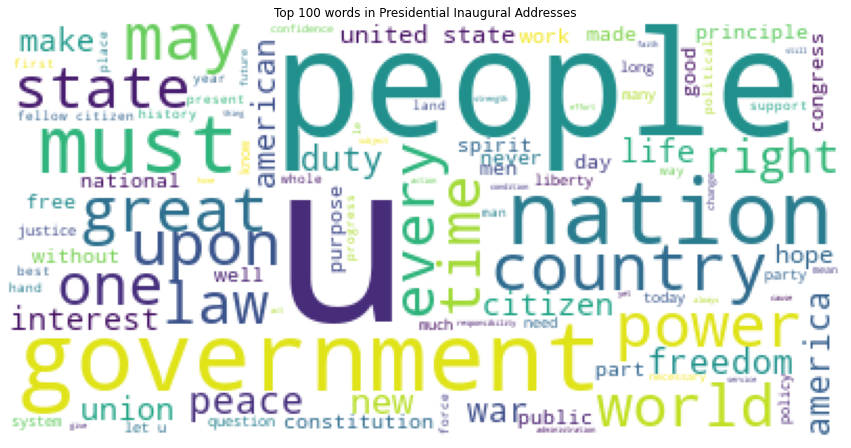

In [10]:
fig,axs = plt.subplots(1,figsize=(15,15))
axs.imshow(wc(background_color='white',max_words=100).generate(''.join(speeches_df_preprocessed.lemmatized_tok_txt_wo_stopwords.tolist())))
axs.axis('off')
axs.set_title('Top 100 words in Presidential Inaugural Addresses')

### Perform LDA on dataset

In [16]:
id2word = gm.corpora.Dictionary(speeches_df_preprocessed['lemmatized_tok_txt_wo_stopwords'].apply(lambda x: x.split()))

In [17]:
scores = []
for n_topics in tqdm(np.arange(10,210,10)):
    lda_gensim = gm.models.ldamodel.LdaModel(corpus=gm.matutils.Sparse2Corpus(X),
                                         num_topics=n_topics,
                                         id2word=id2word
                                        )
    coherence_score = gm.models.coherencemodel.CoherenceModel(model=lda_gensim, texts=speeches_df_preprocessed['lemmatized_tok_txt_wo_stopwords'].apply(lambda x:x.split()), dictionary=id2word, coherence='c_v').get_coherence()
    scores.append(coherence_score)
print(f'Best Number of Topics:{np.arange(10,210,10)[np.argmax(scores)]} with coherence score of {max(scores)}')

  0%|          | 0/20 [00:00<?, ?it/s]

Best Number of Topics:110 with coherence score of 0.6310523684979004


Text(0, 0.5, 'Coherence Score')

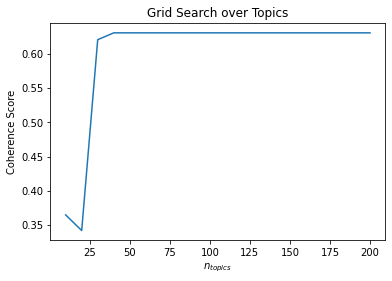

In [18]:
plt.plot(np.arange(10,210,10),scores)
plt.title('Grid Search over Topics')
plt.xlabel(r'$n_{topics}$')
plt.ylabel('Coherence Score')

#### Get $P(T|D),P(T|W)$

In [19]:
N_TOPICS = 20
print(f'Number of topics to be found: {N_TOPICS}')
lda_sklearn = LDA(n_components=N_TOPICS)
logits = lda_sklearn.fit_transform(X)
logits.shape,lda_sklearn.components_.shape

Number of topics to be found: 20


((58, 20), (20, 7771))

In [20]:
lda_gensim = gm.models.ldamodel.LdaModel(corpus=gm.matutils.Sparse2Corpus(X),
                                         num_topics=N_TOPICS,
                                         id2word=id2word
                                        )

#### Get top $N$ terms occuring in each of the $T$ topics

In [21]:
N_TERMS = 5
N_TOPICS_TO_DISPLAY=10
topic_words_sklearn = word2topic_sklearn(lda_sklearn.components_,words=tfidf.vocabulary_,n_terms=N_TERMS,n_topics=N_TOPICS_TO_DISPLAY)
print(f'Top {N_TERMS} words occuring in each of the {N_TOPICS} topics using sklearn')
for topic,terms in topic_words_sklearn.items():
    terms = ', '.join(terms)
    print(f'Topic {topic}: {terms}')

Top 5 words occuring in each of the 20 topics using sklearn
Topic 0: clearly, tempted, dy, dependable, religiously
Topic 1: overruling, instructed, accomplishment, protest, eradication
Topic 2: desperate, liberating, bombastic, depression, acquired
Topic 3: thou, caught, labor, thinking, reared
Topic 4: undeveloped, clearly, restriction, command, shining
Topic 5: annexation, correspondent, uncanny, fulfilling, sharpest
Topic 6: acquired, export, perpetuation, wallet, object
Topic 7: virginia, nd, affirms, exacting, prerequisite
Topic 8: ready, taint, inquire, worker, advocated
Topic 9: adopted, satisfying, triumphant, caution, characterize
Topic 10: bigger, wronged, earlier, supplemented, medicare
Topic 11: devising, bewildered, owes, judiciary, taxgatherer
Topic 12: retaining, travail, amendment, earner, educate
Topic 13: colorable, distinctively, legislation, satisfactorily, attempt
Topic 14: prosecuted, smother, exhibition, deepened, energetically
Topic 15: disappeared, ascendancy, 

In [22]:
topic_words_gensim = word2topic_gensim(lda_gensim,X,id2word,N_TOPICS,N_TERMS)
print(f'Top {N_TERMS} words occuring in each of the {N_TOPICS} topics using gensim')
for topic,terms in topic_words_gensim.items():
    terms = ', '.join(terms)
    print(f'Topic {topic}: {terms}')

Top 5 words occuring in each of the 20 topics using gensim
Topic 0: affectionate, affection, add, acquit, actual
Topic 1: accordingly, aid, advantage, affair, animosity
Topic 2: adorn, along, adore, almighty, advanced
Topic 3: addition, adorn, adore, advantage, add
Topic 4: adorn, adore, appreciation, addition, anticipation
Topic 5: attention, asylum, awaken, another, arising
Topic 6: almighty, adorn, ardent, advantage, addition
Topic 7: adorn, addressed, advanced, adore, assembled
Topic 8: adorn, alteration, appreciation, assure, addition
Topic 9: alteration, american, animosity, advancement, addition
Topic 10: adorn, addition, adore, along, affair
Topic 11: advantage, adore, almighty, addition, assembled
Topic 12: arising, article, assemblage, await, assembled
Topic 13: await, benediction, aver, article, arising
Topic 14: administration, act, actual, along, affair
Topic 15: benefit, benign, avoid, anxiety, aver
Topic 16: attribute, auspiciously, awakened, another, benefit
Topic 17: a

#### Get top $20\%$ of topics assigned to each document

In [23]:
N_TOPICS_PER_DOC=5
print(f'Top {N_TOPICS_PER_DOC} topics appearing in each of the {X.shape[0]} documents using sklearn')
topic_docs = topics2docs_sklearn(logits,N_TOPICS_PER_DOC)
for doc,topics in topic_docs.items():
    topics = ', '.join([str(topic) for topic in topics])
    name = speeches_df_preprocessed.iloc[doc]['Name']
    ia = speeches_df_preprocessed.iloc[doc]['Inaugural Address']
    print(f'{name}\'s Inaugural Address #{ia}: {topics}')

Top 5 topics appearing in each of the 58 documents using sklearn
George Washington's Inaugural Address #1: 4, 15, 10, 12, 7
George Washington's Inaugural Address #2: 16, 15, 7, 12, 10
John Adams's Inaugural Address #1: 15, 7, 12, 10, 19
Thomas Jefferson's Inaugural Address #1: 15, 0, 7, 10, 12
Thomas Jefferson's Inaugural Address #2: 15, 16, 7, 10, 12
James Madison's Inaugural Address #1: 4, 15, 10, 7, 12
James Madison's Inaugural Address #2: 13, 15, 7, 10, 19
James Monroe's Inaugural Address #1: 10, 15, 12, 7, 19
James Monroe's Inaugural Address #2: 12, 15, 10, 7, 19
John Quincy Adams's Inaugural Address #1: 15, 10, 0, 12, 7
Andrew Jackson's Inaugural Address #1: 15, 9, 10, 12, 7
Andrew Jackson's Inaugural Address #2: 15, 11, 7, 10, 12
Martin Van Buren's Inaugural Address #1: 10, 15, 7, 12, 19
William Henry Harrison's Inaugural Address #1: 15, 16, 10, 7, 12
James Knox Polk's Inaugural Address #1: 15, 10, 3, 7, 12
Zachary Taylor's Inaugural Address #1: 19, 15, 7, 12, 10
Franklin Pierce

In [24]:
N_TOPICS_PER_DOC=5
print(f'Top {N_TOPICS_PER_DOC} topics appearing in each of the {X.shape[0]} documents using gensimn')
topic_docs_gensim = topics2docs_gensim(lda_gensim,X,N_TOPICS_PER_DOC)
for doc,topics in topic_docs_gensim.items():
    topics = ', '.join([str(topic) for topic in topics])
    name = speeches_df_preprocessed.iloc[doc]['Name']
    ia = speeches_df_preprocessed.iloc[doc]['Inaugural Address']
    print(f'{name}\'s Inaugural Address #{ia}: {topics}')

Top 5 topics appearing in each of the 58 documents using gensimn
George Washington's Inaugural Address #1: 15, 14, 19, 8, 1
George Washington's Inaugural Address #2: 15, 14, 19, 9, 16
John Adams's Inaugural Address #1: 15, 14, 19, 8, 1
Thomas Jefferson's Inaugural Address #1: 15, 14, 9, 19, 16
Thomas Jefferson's Inaugural Address #2: 15, 19, 8, 1, 2
James Madison's Inaugural Address #1: 15, 14, 0, 8, 1
James Madison's Inaugural Address #2: 15, 19, 8, 1, 2
James Monroe's Inaugural Address #1: 14, 15, 19, 8, 1
James Monroe's Inaugural Address #2: 15, 19, 8, 1, 2
John Quincy Adams's Inaugural Address #1: 15, 14, 19, 8, 1
Andrew Jackson's Inaugural Address #1: 14, 19, 8, 1, 2
Andrew Jackson's Inaugural Address #2: 15, 14, 19, 8, 1
Martin Van Buren's Inaugural Address #1: 14, 15, 19, 8, 1
William Henry Harrison's Inaugural Address #1: 15, 19, 8, 1, 2
James Knox Polk's Inaugural Address #1: 14, 15, 19, 8, 1
Zachary Taylor's Inaugural Address #1: 15, 14, 19, 8, 1
Franklin Pierce's Inaugural A

#### Visualize Topic Distributions 

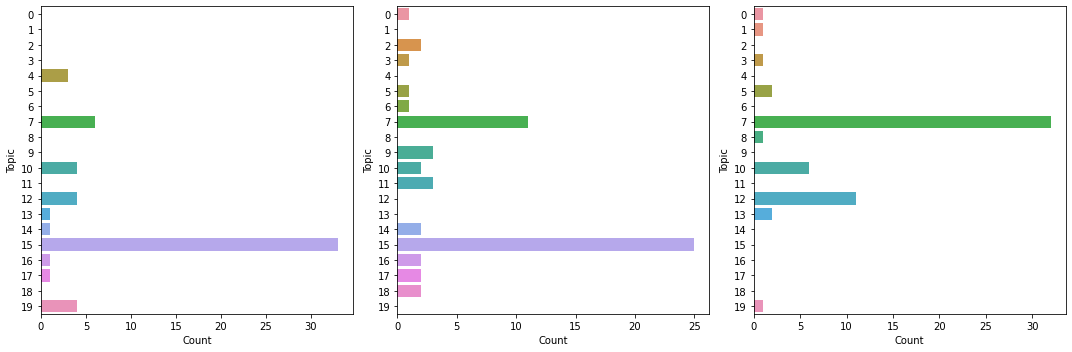

In [25]:
fig,axs = plt.subplots(1,3,figsize=(15,5))
for i in range(3):
    count = {k:0 for k in range(N_TOPICS)}
    for j in [topics[i] for topics in topic_docs.values()]:
        count[j] += 1
    count = pd.DataFrame(count.values(),columns=['Count'])
    count['Topic'] = np.arange(len(count))
    sns.barplot(count,x='Count',y='Topic',orient='horizontal',ax=axs[i])
fig.tight_layout()

#### Visualize with *tSNE*

/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


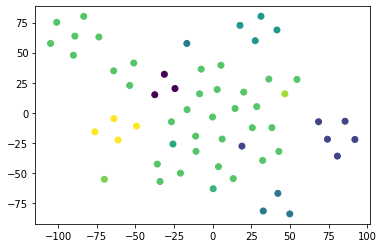

In [26]:
clusters = TSNE(n_components = 2).fit_transform(logits)
plt.scatter(clusters[:,0],clusters[:,1],c = [topic[0] for topic in topic_docs.values()])